In [1]:
B = 80
L = 30
D = 4.4 

import gmsh 
from CompositeSandwich.box_labeling import box_labeling
from djccx.inp.inp import inp
import numpy as np

def Test(D,B,L):
    # create a box with Lx = L , Ly = B, Lz = D
    gmsh.initialize()

    gmsh.model.add("box")

    box = gmsh.model.occ.addBox(0, 0, 0, L, B, D)
    # add box physical group
    gmsh.model.occ.synchronize()
    ph = gmsh.model.addPhysicalGroup(3, [box], -1)
    gmsh.model.setPhysicalName(3, ph, "BOX")

    # synco 
    gmsh.model.occ.synchronize()

    # label the box
    box_labeling(box,"BOX")
    gmsh.model.occ.synchronize()

    # set mesh size
    ms = 1
    gmsh.model.mesh.setSize(gmsh.model.getEntities(0), ms)
    # mesh 
    gmsh.model.mesh.generate(3)
    # quadratic elements
    gmsh.model.mesh.setOrder(2)
    # save in inp format
    gmsh.write("box.inp")


    inp_f = inp("box.inp")
    # select points that satisfy the condition x = 0 and z = 0


    nodes = inp_f.nodes.df
    nodes = nodes[(nodes["x"] == L) & (nodes["z"] == 0)]
    SUPPORT = inp_f.CreateNsetFromIds(nodes.index,"SUPPORT")

    nodes = inp_f.nodes.df
    nodes = nodes[(nodes["x"] == 0) & (nodes["z"] == D)]
    LOAD = inp_f.CreateNsetFromIds(nodes.index,"LOAD")

    xplane = inp_f.select("BOX_X0","elset")
    SYMMETRY  = inp_f.CreateNsetFromElset(xplane,"SYMMETRY")
    # remove 1 and 2 
    inp_f.remove_by_type(1)
    inp_f.remove_by_type(2)

    #
    E = 1e6
    nu = 0.3
    name = "Elastic"
    mat = inp_f.CreateElasticMaterial(name,E,nu)
    all = inp_f.CreateElsetAll()
    sec = inp_f.CreateSolidSection(all,mat)

    # 
    istep = inp_f.CreateStaticStep()
    istep.CreateBoundary(LOAD,3,displ=-3)
    istep.CreateBoundary(SUPPORT,3,displ=0)
    istep.CreateBoundary(SYMMETRY,1,displ=0)

    ifrd = inp_f.run("output")


    nodes = inp_f.nodes.df

    nodes = nodes[(nodes["x"]  == 0) & (nodes["z"] ==  D)]
    nodes = nodes.copy()

    nodes["F3"] = ifrd["data"]["F3"][nodes.index]
    F = - nodes["F3"].sum()



    nodes = inp_f.nodes.df
    nodes = nodes[(nodes["x"] == 0) & (nodes["z"] ==  0)]

    nodes = nodes.copy()

    nodes["P1"] = ifrd["data"]["P1"][nodes.index]

    Pmax = nodes["P1"].max()


    D_eq = E*B*D**3 / (12*(1-nu**2))
    Pmax_teorico = (16/np.pi) * ((2*F)*(2*L)**2) / (D_eq)


    print(f"Pmax = {Pmax}")
    print(f"Pmax_teorico = {Pmax_teorico}")
    print(f"Error = {100*abs(Pmax - Pmax_teorico)/Pmax_teorico} %")

    gmsh.finalize()
    error = 100*abs(Pmax - Pmax_teorico)/Pmax_teorico

    return error


In [22]:
import numpy as np 


In [23]:
errors = []
error_span = np.linspace(10,100,15)
for B in error_span:
    error = Test(D,B,L)
    errors.append(error)



Running Calculix at:  output
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_BendingTest\NumericalBasicRotura\output\out.txt
Command:
 C:\Program Files\Microsoft MPI\Bin\mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  16204 

Calculix finished

Pmax = 21837.90303928805
Pmax_teorico = 21684.154927685944
Error = 0.7090343714792483 %
Running Calculix at:  output
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_BendingTest\NumericalBasicRotura\output\out.txt
Command:
 C:\Program Files\Microsoft MPI\Bin\mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  18408 

Calculix finished

Pmax = 23244.50013639762
Pmax_teorico = 21948.67786740926
Error = 5.903873922686135 %
Running Calculix at:  output
Output file:  c:\Users\dj

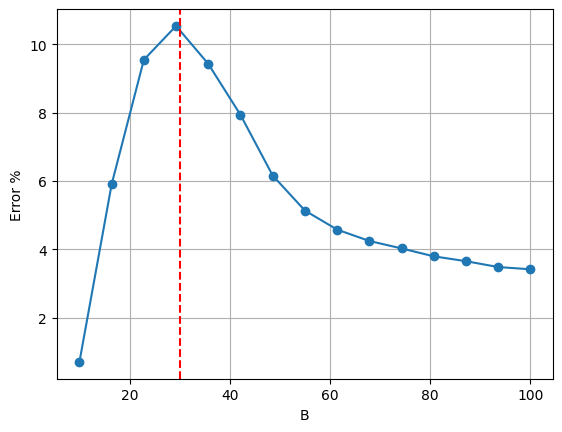

In [29]:
from matplotlib import pyplot as plt

plt.plot(error_span,errors,"-o")
plt.xlabel("B") 
plt.ylabel("Error %")
# vertical line 
plt.axvline(x=L, color='r', linestyle='--')
plt.grid()
plt.show()

In [25]:
from matplotlib import pyplot as plt

In [26]:
plt.plot(nodes["y"],nodes["F3"],".")
plt.xlabel("y")
plt.ylabel("F3")

NameError: name 'nodes' is not defined

Text(0, 0.5, 'P1')

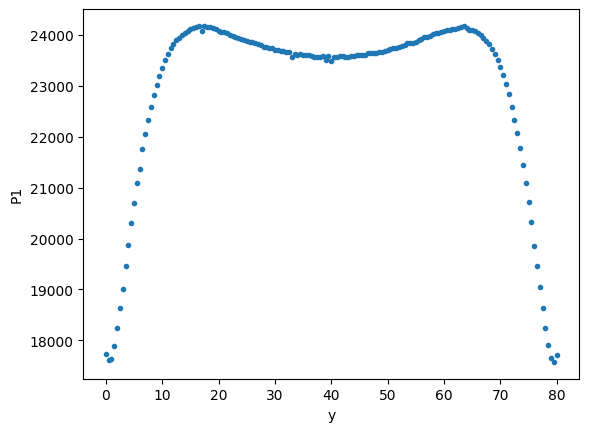

Pmax = 24177.00366791482
Pmax_teorico = 23291.419358212803
Error = 3.802191253706281 %
